In [59]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\glandrum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
d = pd.read_csv('../data/chembl_5HT.csv')
d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220F4518D30>]],
      dtype=object)

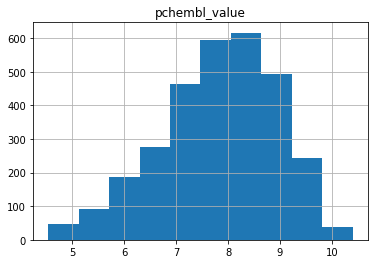

In [6]:
# pull 5-HT6
assay = d.loc[d['target_chembl_id']=='CHEMBL3371']
assay.hist('pchembl_value')

In [12]:
len(assay.loc[assay['pchembl_value']>9.0]),len(assay.loc[assay['pchembl_value']<8.5])

(404, 2137)

In [48]:
acts = assay.loc[assay['pchembl_value']>9.0]
inacts = assay.loc[assay['pchembl_value']<8.5]
act_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))
    
    
inact_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))


In [61]:
import sklearn
import random
random.seed(0xf00d)
nAct = len(act_data)
actis = list(range(nAct))
nInact = len(inact_data)
inactis = list(range(nInact))
random.shuffle(actis)
random.shuffle(inactis)

train_pct = 0.80
train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

random.shuffle(train)
random.shuffle(test)


In [62]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
cls.fit([y for x,y,z in train],[z for x,y,z in train])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

kappa: 0.606
[[417  11]
 [ 36  45]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95       428
          1       0.80      0.56      0.66        81

avg / total       0.90      0.91      0.90       509



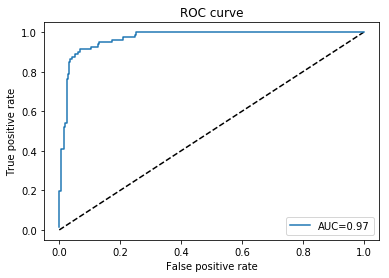

In [70]:
from sklearn import metrics
scores = cls.predict([y for x,y,z in test])
print('kappa: %.3f'%metrics.cohen_kappa_score([z for x,y,z in test],scores))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))
probs = cls.predict_proba([y for x,y,z in test])[:,1]
auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
fpr, tpr, thresholds = metrics.roc_curve([z for x,y,z in test], probs, pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC=%.2f'%auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [77]:
# balanced prediction
thresh = min(2*nAct/(nAct+nInact),0.5)
probs = cls.predict_proba([y for x,y,z in test])[:,1]
scores = [1 if x>=thresh else 0 for x in probs]
print('kappa: %.3f'%metrics.cohen_kappa_score([z for x,y,z in test],scores))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))


kappa: 0.813
[[413  15]
 [ 11  70]]
             precision    recall  f1-score   support

          0       0.97      0.96      0.97       428
          1       0.82      0.86      0.84        81

avg / total       0.95      0.95      0.95       509



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220F8A66470>]],
      dtype=object)

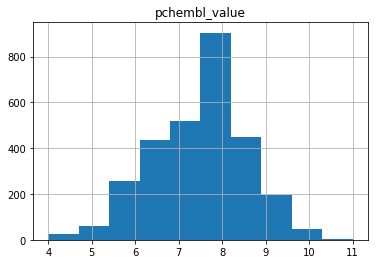

In [78]:
# pull 5-HT2a
assay = d.loc[d['target_chembl_id']=='CHEMBL224']
assay.hist('pchembl_value')

In [79]:
len(assay.loc[assay['pchembl_value']>9.0]),len(assay.loc[assay['pchembl_value']<8.5])

(211, 2477)

kappa: 0.714
[[494   2]
 [ 17  26]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       496
          1       0.93      0.60      0.73        43

avg / total       0.96      0.96      0.96       539



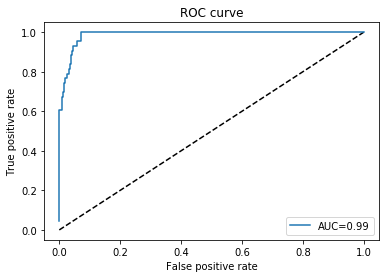

In [81]:
acts = assay.loc[assay['pchembl_value']>9.0]
inacts = assay.loc[assay['pchembl_value']<8.5]
act_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))
    
    
inact_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    import sklearn
import random
random.seed(0xf00d)
nAct = len(act_data)
actis = list(range(nAct))
nInact = len(inact_data)
inactis = list(range(nInact))
random.shuffle(actis)
random.shuffle(inactis)

train_pct = 0.80
train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

random.shuffle(train)
random.shuffle(test)

from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
cls.fit([y for x,y,z in train],[z for x,y,z in train])
from sklearn import metrics
scores = cls.predict([y for x,y,z in test])
print('kappa: %.3f'%metrics.cohen_kappa_score([z for x,y,z in test],scores))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))
probs = cls.predict_proba([y for x,y,z in test])[:,1]
auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
fpr, tpr, thresholds = metrics.roc_curve([z for x,y,z in test], probs, pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC=%.2f'%auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [88]:
# balanced prediction
thresh = min(2*nAct/(nAct+nInact),0.5)
thresh = 0.2
probs = cls.predict_proba([y for x,y,z in test])[:,1]
scores = [1 if x>=thresh else 0 for x in probs]
print('kappa: %.3f'%metrics.cohen_kappa_score([z for x,y,z in test],scores))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))


kappa: 0.724
[[474  22]
 [  4  39]]
             precision    recall  f1-score   support

          0       0.99      0.96      0.97       496
          1       0.64      0.91      0.75        43

avg / total       0.96      0.95      0.96       539



In [87]:
min(2*nAct/(nAct+nInact),0.5)


0.15699404761904762

In [89]:
# pull 5-HT1a
assay = d.loc[d['target_chembl_id']=='CHEMBL214']
print(len(assay.loc[assay['pchembl_value']>9.0]),len(assay.loc[assay['pchembl_value']<8.5]))

213 1974


In [96]:
acts = assay.loc[assay['pchembl_value']>9.0]
inacts = assay.loc[assay['pchembl_value']<8.5]
act_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))
    
    
inact_data = []
for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
    bv = np.zeros((len(fp),),np.int16)
    DataStructs.ConvertToNumpyArray(fp,bv)
    inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    import sklearn
import random
random.seed(0xf00d)
nAct = len(act_data)
actis = list(range(nAct))
nInact = len(inact_data)
inactis = list(range(nInact))
random.shuffle(actis)
random.shuffle(inactis)

train_pct = 0.80
train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

random.shuffle(train)
random.shuffle(test)

from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
cls.fit([y for x,y,z in train],[z for x,y,z in train])
from sklearn import metrics
scores = cls.predict([y for x,y,z in test])
probs = cls.predict_proba([y for x,y,z in test])[:,1]
auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
print('kappa: %.3f, AUC: %.3f'%(metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))

kappa: 0.471, AUC: 0.950
[[393   2]
 [ 28  15]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       395
          1       0.88      0.35      0.50        43

avg / total       0.93      0.93      0.92       438



In [94]:
# balanced prediction
thresh = min(2*nAct/(nAct+nInact),0.5)
#thresh = 0.3
probs = cls.predict_proba([y for x,y,z in test])[:,1]
scores = [1 if x>=thresh else 0 for x in probs]
print('kappa: %.3f'%metrics.cohen_kappa_score([z for x,y,z in test],scores))
print(metrics.confusion_matrix([z for x,y,z in test],scores))
print(metrics.classification_report([z for x,y,z in test],scores))


kappa: 0.652
[[370  25]
 [  7  36]]
             precision    recall  f1-score   support

          0       0.98      0.94      0.96       395
          1       0.59      0.84      0.69        43

avg / total       0.94      0.93      0.93       438



In [92]:
min(2*nAct/(nAct+nInact),0.5)


0.19478737997256515

In [102]:
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def run_it(acts,inacts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))


    inact_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    random.seed(0xf00d)
    nAct = len(act_data)
    actis = list(range(nAct))
    nInact = len(inact_data)
    inactis = list(range(nInact))
    random.shuffle(actis)
    random.shuffle(inactis)

    train_pct = 0.80
    train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
    test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

    random.shuffle(train)
    random.shuffle(test)

    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
    cls.fit([y for x,y,z in train],[z for x,y,z in train])
    scores = cls.predict([y for x,y,z in test])
    probs = cls.predict_proba([y for x,y,z in test])[:,1]
    auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
    print('ratio: %.3f kappa: %.3f, AUC: %.3f'%(nAct/nInact,metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc))
    print(metrics.confusion_matrix([z for x,y,z in test],scores))
    print(metrics.classification_report([z for x,y,z in test],scores))
    return probs,[z for x,y,z in test]

In [103]:
acts = assay.loc[assay['pchembl_value']>9.0]
inacts = assay.loc[assay['pchembl_value']<8.5]
ps,tgt = run_it(acts,inacts)

ratio: 0.108 kappa: 0.471, AUC: 0.952
[[393   2]
 [ 28  15]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       395
          1       0.88      0.35      0.50        43

avg / total       0.93      0.93      0.92       438



In [104]:
# balanced prediction
thresh = 0.3
scores = [1 if x>=thresh else 0 for x in ps]
print('kappa: %.3f'%metrics.cohen_kappa_score(tgt,scores))
print(metrics.confusion_matrix(tgt,scores))
print(metrics.classification_report(tgt,scores))


kappa: 0.706
[[383  12]
 [ 11  32]]
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       395
          1       0.73      0.74      0.74        43

avg / total       0.95      0.95      0.95       438



ratio: 0.085 kappa: 0.714, AUC: 0.987
[[494   2]
 [ 17  26]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       496
          1       0.93      0.60      0.73        43

avg / total       0.96      0.96      0.96       539



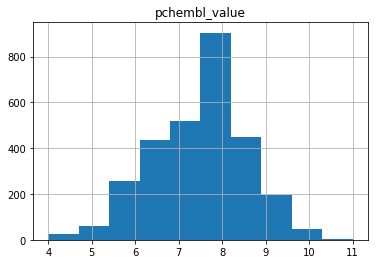

In [105]:
# pull 5-HT2a
assay = d.loc[d['target_chembl_id']=='CHEMBL224']
assay.hist('pchembl_value')
acts = assay.loc[assay['pchembl_value']>9.0]
inacts = assay.loc[assay['pchembl_value']<8.5]
ps,tgt = run_it(acts,inacts)


In [107]:
thresh = 0.3
scores = [1 if x>=thresh else 0 for x in ps]
print('thresh: %.3f kappa: %.3f'%(thresh,metrics.cohen_kappa_score(tgt,scores)))
print(metrics.confusion_matrix(tgt,scores))
print(metrics.classification_report(tgt,scores))


thresh: 0.300 kappa: 0.757
[[487   9]
 [ 10  33]]
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       496
          1       0.79      0.77      0.78        43

avg / total       0.96      0.96      0.96       539

